In [1]:
!pip install -q --upgrade keras-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 11.3 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.20.0 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import keras
import keras_hub

import tensorflow.strings as tf_strings
import tensorflow.data as tf_data

2025-05-10 02:13:48.229988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746843228.702568      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746843228.843650      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_params = {
    "BATCH_SIZE" : 16,
    "SEQ_LEN" : 128
}

In [5]:
model_params = {
    "EMBED_DIM" : 256,
    "FF_DIM" : 128,
    "N_HEADS" : 3,
    "N_LAYERS" : 2,
    "VOCAB_SIZE" : 7133
}

In [6]:
df = pd.read_csv('/kaggle/input/taylorswiftlyrics/taylor_swift_lyrics.csv')
df.dropna(inplace=True)
df.head()

,Song,Lyrics
0,"""Slut!"" (Taylor's Version) (From The Vault)","[Verse 1]\nFlamingo pink, Sunrise Boulevard\nC..."
1,22 (Taylor's Version),[Verse 1]\nIt feels like a perfect night\nTo d...
2,A Perfectly Good Heart,[Chorus]\nWhy would you wanna break\nA perfect...
3,A Place in this World,"[Verse 1]\nI don't know what I want, so don't ..."
4,Afterglow,"[Verse 1]\nI blew things out of proportion, no..."


In [7]:
dataset = tf_data.experimental.make_csv_dataset(
    file_pattern = '/kaggle/input/taylorswiftlyrics/taylor_swift_lyrics.csv',
    batch_size = data_params["BATCH_SIZE"],
    label_name = 'Lyrics',
    num_epochs = 1,
    shuffle = True
)

I0000 00:00:1746843248.324261      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746843248.324991      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
features, label = dataset.take(1).get_single_element()
print("Song:", features['Song'].numpy()[0].decode())
print("Lyrics:", label.numpy()[0].decode())

Song: You Belong With Me (Taylor’s Version)
Lyrics: [Verse 1]
You're on the phone with your girlfriend, she's upset
She's goin' off about something that you said
'Cause she doesn't get your humor like I do
I'm in my room, it's a typical Tuesday night
I'm listening to the kind of music she doesn't like
And she'll never know your story like I do
[Pre-Chorus]
'Cause she wears short skirts, I wear T-shirts
She's Cheer Captain and I'm on the bleachers
Dreaming 'bout the day when you wake up and find
That what you're lookin' for has been here the whole time
[Chorus]
If you could see that I'm the onе who understands you
Been here all along, so why can't you see?
You bеlong with me, you belong with me
[Verse 2]
Walking the streets with you and your worn-out jeans
I can't help thinking this is how it ought to be
Laughin' on a park bench, thinking to myself
"Hey, isn't this easy?"
And you've got a smile that could light up this whole town
I haven't seen it in a while since she brought you down
Y

In [9]:
lyrics_only = dataset.map(lambda features, label: label).unbatch()

In [10]:
vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
    lyrics_only,
    vocabulary_size = model_params["VOCAB_SIZE"],
    lowercase = True,
    reserved_tokens = ["[PAD]", "[UNK]", "[BOS]"]
)

In [11]:
tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary = vocab,
    sequence_length = data_params["SEQ_LEN"],
    lowercase = True
)

In [14]:
start_packer = keras_hub.layers.StartEndPacker(
    sequence_length = data_params["SEQ_LEN"],
    start_value = tokenizer.token_to_id("[BOS]")
)

In [15]:
def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels

In [34]:
train_ds = lyrics_only.map(
    preprocess,
    num_parallel_calls = tf_data.AUTOTUNE
).prefetch(
    tf_data.AUTOTUNE
).batch(data_params["BATCH_SIZE"])

In [35]:
input_layer = keras.layers.Input(shape=(None,), dtype="int32")

embedding_layer = keras_hub.layers.TokenAndPositionEmbedding(
    vocabulary_size = model_params["VOCAB_SIZE"],
    sequence_length = data_params["SEQ_LEN"],
    embedding_dim = model_params["EMBED_DIM"],
    mask_zero = True
)

In [36]:
x = embedding_layer(input_layer)

for _ in range(model_params["N_LAYERS"]):
    decoder_layer = keras_hub.layers.TransformerDecoder(
        num_heads = model_params["N_HEADS"],
        intermediate_dim = model_params["FF_DIM"]
    )
    x = decoder_layer(x)

In [37]:
outputs = keras.layers.Dense(model_params["VOCAB_SIZE"])(x)

In [49]:
model = keras.Model(inputs=input_layer, outputs=outputs, name="SwiftGPT-v1")

In [39]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_hub.metrics.Perplexity(from_logits=True, mask_token_id=0)

In [50]:
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [51]:
model.summary()

Model: "SwiftGPT-v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, None, 256)           │       1,858,816 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_2                │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_3                │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 7133)          │       1,833,181 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,350,167 (16.59 MB)

 Trainable params: 4,350,167 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
 history = model.fit(
     train_ds,
     epochs = 20
 )

Epoch 1/20


W0000 00:00:1746850208.211305      99 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1746850208.221525      99 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     12/Unknown 11s 22ms/step - loss: 3.1304 - perplexity: 23.8077

W0000 00:00:1746850210.906930     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1746850210.913630     100 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - loss: 3.1363 - perplexity: 23.8295
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8966 - perplexity: 18.1070
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7464 - perplexity: 15.5865
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.5984 - perplexity: 13.4410
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4276 - perplexity: 11.3330
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.3172 - perplexity: 10.1478
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1771 - perplexity: 8.8192
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.0397 - perplexity: 7.6867
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8967 - perplexity: 6.6629
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7646 - perplexity: 5.8400
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6604 - perplexity: 5.2620
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19

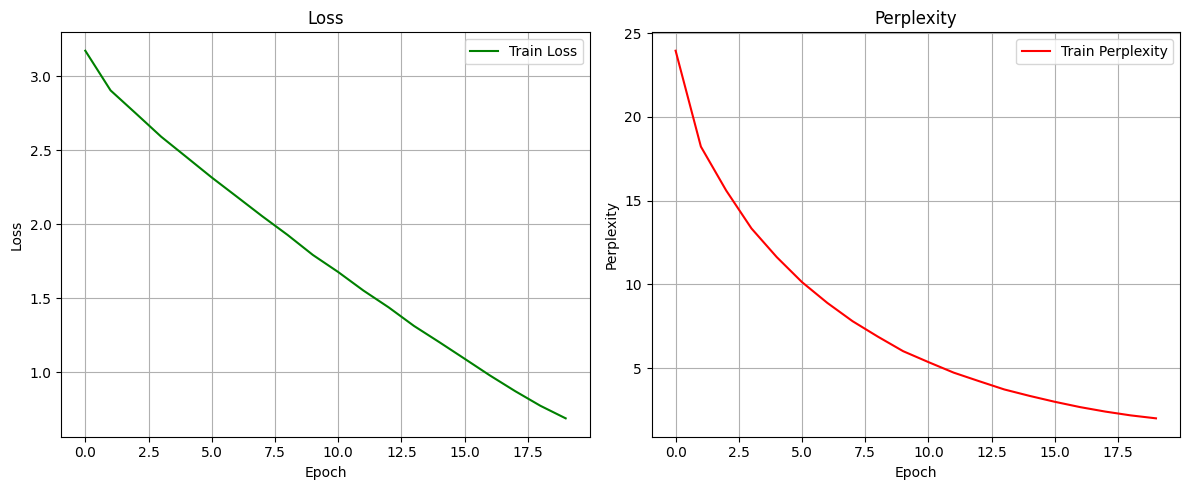

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axs[0].plot(history.history['loss'], label='Train Loss', color='green')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot Perplexity
axs[1].plot(history.history['perplexity'], label='Train Perplexity', color='red')
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [54]:
# The "packer" layers adds the [BOS] token for us.
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [55]:
def next(prompt, cache, index):
    logits = model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search
    hidden_states = None
    return logits, hidden_states, cache

In [56]:
sampler = keras_hub.samplers.TopPSampler(p=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
['[BOS] [ verse 1 ] we \' re close to mine as long as they don \' t touch out of fob and locks the door the wind , but i stood right the way it works the fuck was the whole life [ chorus ] but i know you never be one of the ground it seems to dance but you \' re the reason and i got it \' re daction but i can see useve takes one to the rumors from in the fancy shit and watch you \' ll be someone who \' re in me " [ chorus ] and this town is fake , baby don \' t know that i']

